In [7]:
import sys
sys.path.append('/Users/abdielfer/RNCanWork/DL4Flood/')

import dataLoader as D
import util as U
import torch
import models_trainer
import losses as L
from losses import iou_binary
from torch.optim import Adam 
# subfolder import:
from model_set.models import UNetFlood


trn_listPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/template_project_feat1_min-annot10_trn.csv'
val_listPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/template_project_feat1_min-annot10_val.csv'

args = {'savepath':trn_listPath, 'batch_size': 1, 'num_workers': 1,'drop_last': True}

train_set = D.customDataloader(D.customDataSet(trn_listPath, True),args).getDataloader()
val_set = D.customDataloader(D.customDataSet(val_listPath),args).getDataloader()

# rasterPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/trn/VilleGatineau-1/images/'

In [8]:
model = UNetFlood(1,1)
loss_fn = L.lovasz_hinge
optimizer = Adam(model.parameters(), lr = 0.0001)
metric = iou_binary

trainer = models_trainer.models_trainer(model,loss_fn,optimizer,metric)
trainer.set_loaders(train_set,val_set)

In [9]:
trainer.train(1)

Epoch 0 ........ ->
Encoding______
input_data torch.Size([1, 1, 384, 384])
conv1 torch.Size([1, 64, 384, 384])
maxpool1 torch.Size([1, 64, 192, 192])
conv2 torch.Size([1, 128, 192, 192])
maxpool2 torch.Size([1, 128, 96, 96])
conv3 torch.Size([1, 256, 96, 96])
maxpool3 torch.Size([1, 256, 48, 48])
conv4 torch.Size([1, 512, 48, 48])
maxpool4 torch.Size([1, 512, 24, 24])
center ______
center torch.Size([1, 1024, 24, 24])
Decoding______
decode4 shape torch.Size([1, 512, 48, 48])
decode3 shape torch.Size([1, 256, 96, 96])
decode2 shape torch.Size([1, 128, 192, 192])
decode1 shape torch.Size([1, 64, 384, 384])
setting final ___
self.final(decode1) shape torch.Size([1, 1, 384, 384])
input_data.size()[2:] shape torch.Size([384, 384])
Final shape after interpolating self.final(decode1), input_data.size()[2:]: torch.Size([1, 1, 384, 384])
Encoding______
input_data torch.Size([1, 1, 384, 384])
conv1 torch.Size([1, 64, 384, 384])
maxpool1 torch.Size([1, 64, 192, 192])
conv2 torch.Size([1, 128, 192

In [ ]:
item = next(iter(val_set))
imag = item[0]
mask = item[1]
print('image to model input shape',imag.shape)

model.eval()
Y_hat = model(imag)
print('Y_hat to model input shape',Y_hat.shape)
model.train()


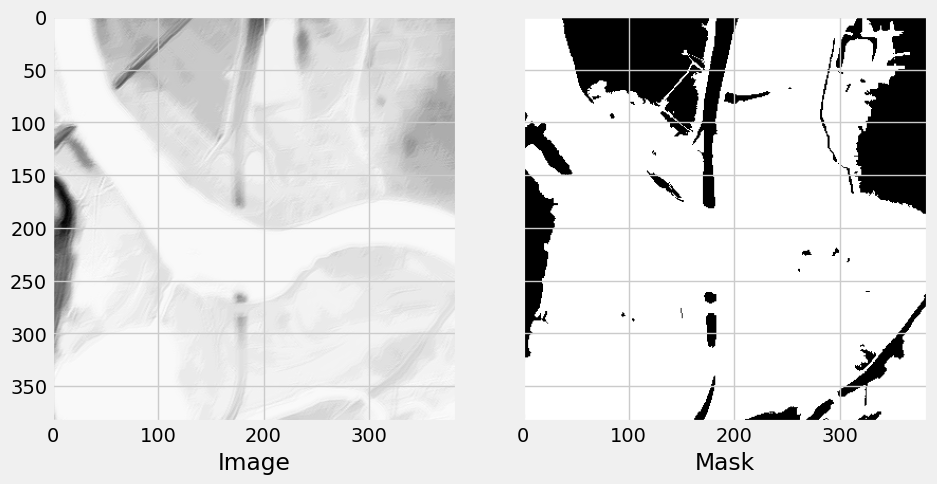

In [11]:
for i in range(0,imag.shape[0]):
    U.plotImageAndMask(Y_hat[i][0], mask[i][0])


In [12]:
##  Works well!
# Testing util.makePredictionRaster() for inference.
inToInfer,_ = U.readRaster(rasterPath)

imgToInferTensor = U.imageToTensor(inToInfer)
print("imgToInferTensor shape: ----", imgToInferTensor.shape)
out = U.makePredictionRaster(rasterPath, model,saveRaster=True)
print('out shape: _____ ',out.shape)


NameError: name 'rasterPath' is not defined

[0.8797356828193833]
87.97356828193833


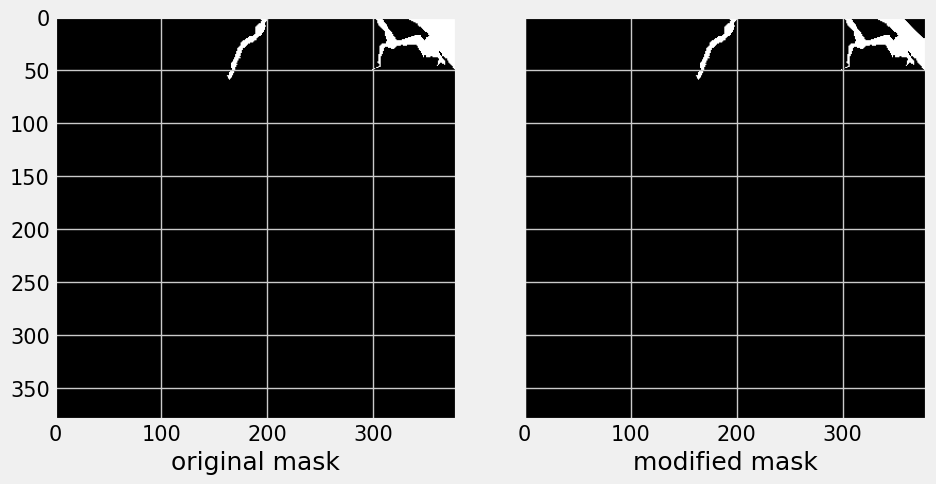

In [11]:
#test IoU
# Modified mask: righ up corner have been removed from real mask in QGIS. Both share CRS, resolution, ect. 
realMask = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/val/VilleGatineau-1/labels_burned/ON_VilleGatineau_440125_777821867_5036548_55970885_feat1_min-annot1.tif'
modifiedMask = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/val/VilleGatineau-1/labels_burned/ON_VilleGatineau_440125_777821867_5036548_55970885_feat1_min-annot1_Modified.tif'

real,_ = U.readRaster(realMask)
modified,_ = U.readRaster(modifiedMask)

ioUB = L.iou_binary(real,modified, per_image=False)
print(ioUB)

U.plotImageAndMask(U.imageToTensor(real)[0],U.imageToTensor(modified)[0],'original mask','modified mask')

#  OUTPUT = 87,987% iou, is a good representation of mask differences. 

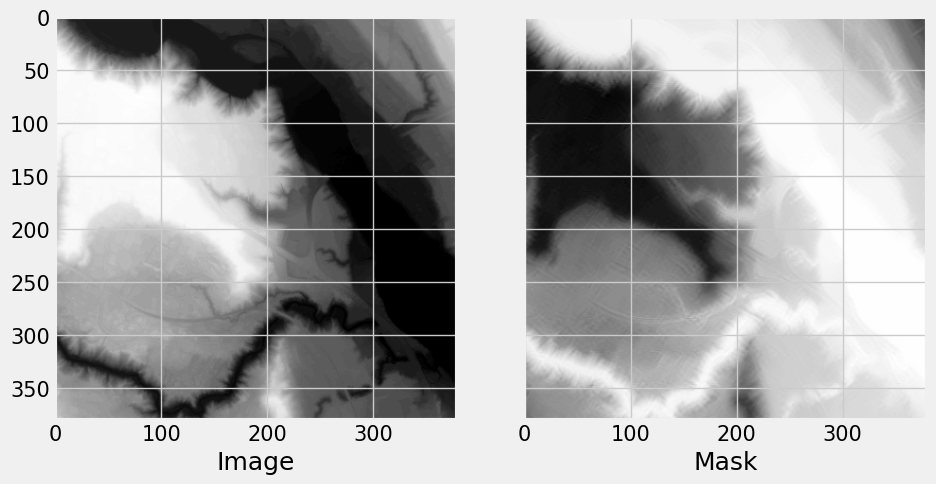

In [21]:
U.plotImageAndMask(imgToInferTensor[0],rasterData[0])

In [12]:
import torch as T
from torch.autograd import Variable

[0.0]
0.0


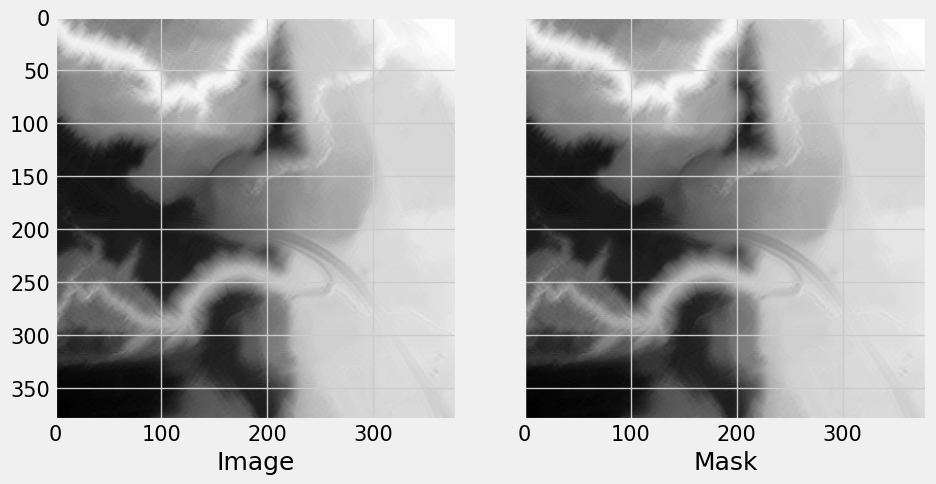

In [25]:
flated = Y_hat[0][0].view(-1)
signs = 2. * Y_hat[0][0].float() - 1.
# print(Y_hat[0][0][0:20,340:350])
# print('signe : ____',signs[0:20,340:350])
# print(signs.shape)
zerosAndOnes = torch.where(signs==-1,torch.tensor(0),signs)
# print(zerosAndOnes[0:20,340:350])
errors = (1. - Y_hat[0][0] * Variable(signs))
U.plotImageAndMask(Y_hat[0][0], zerosAndOnes)
ioUB = L.iou_binary(zerosAndOnes,zerosAndOnes, per_image=False)
print(ioUB)

In [ ]:
####   Apply sigmoid to the output image to compare with Mask...IMportant!!!!
y_hatSigmoided = torch.sigmoid(Y_hat[0][0])
U.plotImageAndMask(y_hatSigmoided, mask[0][0])

In [ ]:
### Visualize all batch image-mask pairs. 
# NOTE :   img, mask = next(iter(train_set))
i = 0
j = 0
for batch in train_set:
    for item in batch:
        print(f"Bathc {i}, item {j}")
        print('item',item.shape)
        j +=1
        
    # U.plotImageAndMask(batch[0][0],batch[1][0])
    i+=1
    j=0  
    print("_______") 


In [ ]:
## Ref: 

from typing import Iterable, List
import torch
import matplotlib.pyplot as plt

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='gray')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

In [ ]:

from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()
     

idx = 0
img = xr.open_rasterio(train_imgs[idx])
mask = xr.open_rasterio(train_masks[idx])
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')